# Covid Research 20210201

***
## 0. Import

In [94]:
import GAN
from GAN import *

import gc
import hdbscan
import importlib
import math
import numpy as np
import operator
import pandas as pd
import psutil
from matplotlib import pyplot as plt

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder, LabelEncoder

seed = 47

gc.collect()
print(list(psutil.virtual_memory())[0:2])

[17179869184, 7078965248]


***
## 1. Read Data

In [95]:
data = pd.read_excel('../data/ed_pred.xlsx')
data = data.reset_index()
print(data.shape)
print(data.columns)
data.head()

(7380, 41)
Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')


,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [97]:
data.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [98]:
data.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [99]:
label_cols = ['COVIDResult']
data_cols = list(data.columns[ data.columns != 'COVIDResult' ])

print(data_cols)
print('# of data columns: ',len(data_cols))

['index', 'patno', 'Admitted', 'AdmittingDepartment', 'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
# of data columns:  40


In [100]:
data.groupby('COVIDResult')['COVIDResult'].count()

COVIDResult
Detected          470
None Detected    6910
Name: COVIDResult, dtype: int64

In [101]:
data.isnull().sum().sum()

69411

In [102]:
normal_duplicates = sum( data.loc[ data.COVIDResult=='None Detected' ].duplicated() )
detected_duplicates = sum( data.loc[ data.COVIDResult=='Detected' ].duplicated() )
total_duplicates = normal_duplicates + detected_duplicates

print('Normal duplicates', normal_duplicates)
print('Detected duplicates', detected_duplicates)
print('Total duplicates', total_duplicates)
print('Fraction duplicated', total_duplicates / len(data))

Normal duplicates 0
Detected duplicates 0
Total duplicates 0
Fraction duplicated 0.0


***
## 2. Preprocess

### 2.1 Select columns

In [103]:
data_GAN = data.copy()

# all features
feature_cols = data_cols

# 12 features
# feature_cols = ['Age', 'FirstRace', 'Ethnicity', 'Sex', 'height', 'wght', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'cmp_glucose']
# remove sbp, dbp
# feature_cols = ['Age', 'FirstRace', 'Ethnicity', 'Sex', 'height', 'wght', 'heart_rate', 'pulse_ox', 'resp_rate', 'cmp_glucose']
# further remove pulse_ox
# feature_cols = ['Age', 'FirstRace', 'Ethnicity', 'Sex', 'height', 'wght', 'heart_rate', 'resp_rate', 'cmp_glucose']
# further remove cmp_glucose
# feature_cols = ['Age', 'FirstRace', 'Ethnicity', 'Sex', 'height', 'wght', 'heart_rate', 'resp_rate']
# further remove resp_rate
# feature_cols = ['Age', 'FirstRace', 'Ethnicity', 'Sex', 'height', 'wght', 'heart_rate']

label_cols = ['COVIDResult']

# categorical features in all
cat_cols = ['AdmittingDepartment', 'FirstRace', 'Ethnicity', 'Sex']
# categorical features in 12
# cat_cols = ['FirstRace', 'Ethnicity', 'Sex']

num_cols = feature_cols.copy()
for i in cat_cols:
    num_cols.remove(i)

data_GAN = data_GAN[feature_cols + label_cols]
train, test = train_test_split(data_GAN, test_size=0.2, random_state=seed)

data_GAN.head()

,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,0,1,1,UVHE MICU,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,...,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5,None Detected
1,1,2,0,NaN,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,...,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6,None Detected
2,2,3,0,NaN,55,African American,Non-Hispanic,Male,83.0,152.0,...,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7,None Detected
3,3,4,1,UVHE MICU,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,...,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5,None Detected
4,4,5,0,NaN,67,African American,Non-Hispanic,Female,90.0,128.0,...,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2,None Detected


### 2.2 Missing values

In [104]:
def numerical_imputer_preprocess(x_num):
    for i in range(len(x_num)):
        for j in range(len(x_num[i])):
            if isinstance(x_num[i][j], str):
                if (ord('0') <= ord(x_num[i][j][0]) <= ord('9')):
                    x_num[i][j] = float(x_num[i][j])
                else:
                    x_num[i][j] = float(x_num[i][j][1:])
                    
    imp = SimpleImputer(strategy='constant', fill_value=0)
    x_num = imp.fit_transform(x_num)
    
    return x_num
        
data_GAN_missing = data_GAN[num_cols]
data_GAN_missing = numerical_imputer_preprocess(data_GAN_missing.values)
data_GAN_without_missing = data_GAN.copy()
data_GAN_without_missing[num_cols] = data_GAN_missing

train_missing = train[num_cols]
train_missing = numerical_imputer_preprocess(train_missing.values)
train_without_missing = train.copy()
train_without_missing[num_cols] = train_missing

test_missing = test[num_cols]
test_missing = numerical_imputer_preprocess(test_missing.values)
test_without_missing = test.copy()
test_without_missing[num_cols] = test_missing

data_GAN_without_missing.head()

,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,0,1,1,UVHE MICU,78,White or Caucasian,Non-Hispanic,Female,94.0,138.0,...,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5,None Detected
1,1,2,0,NaN,23,White or Caucasian,Non-Hispanic,Female,121.0,134.0,...,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6,None Detected
2,2,3,0,NaN,55,African American,Non-Hispanic,Male,83.0,152.0,...,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7,None Detected
3,3,4,1,UVHE MICU,50,White or Caucasian,Non-Hispanic,Male,88.0,138.0,...,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5,None Detected
4,4,5,0,NaN,67,African American,Non-Hispanic,Female,90.0,128.0,...,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2,None Detected


### 2.3 Encoder for categorial values

In [105]:
def categorical_preprocess(x_cat):
    for i in range(len(x_cat)):
        if not isinstance(x_cat[i][0], str):
            x_cat[i][0] = 'NA'
        if not isinstance(x_cat[i][1], str):
            x_cat[i][1] = '*Unspecified'
            
    oe = OrdinalEncoder()
    x_cat = oe.fit_transform(x_cat)
    
    return x_cat

data_GAN_cat = data_GAN[cat_cols]
data_GAN_cat = categorical_preprocess(data_GAN_cat.values)
data_GAN_with_cat = data_GAN_without_missing.copy()
data_GAN_with_cat[cat_cols] = data_GAN_cat

train_cat = train[cat_cols]
train_cat = categorical_preprocess(train_cat.values)
train_with_cat = train_without_missing.copy()
train_with_cat[cat_cols] = train_cat

test_cat = test[cat_cols]
test_cat = categorical_preprocess(test_cat.values)
test_with_cat = test_without_missing.copy()
test_with_cat[cat_cols] = test_cat

data_GAN_with_cat.head()

,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,0,1,1,30.0,78,9.0,2.0,0.0,94.0,138.0,...,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5,None Detected
1,1,2,0,1.0,23,9.0,2.0,0.0,121.0,134.0,...,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6,None Detected
2,2,3,0,1.0,55,1.0,2.0,1.0,83.0,152.0,...,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7,None Detected
3,3,4,1,30.0,50,9.0,2.0,1.0,88.0,138.0,...,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5,None Detected
4,4,5,0,1.0,67,1.0,2.0,0.0,90.0,128.0,...,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2,None Detected


In [106]:
def y_preprocess(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    for i in range(len(y)):
        y[i] = 1 - y[i]
    
    return y

data_GAN_y = data_GAN[label_cols]
data_GAN_y = y_preprocess(data_GAN_y.values.ravel())
data_GAN_with_y = data_GAN_with_cat.copy()
data_GAN_with_y = data_GAN_with_y.drop(label_cols, axis=1)
data_GAN_with_y['COVIDResult'] = data_GAN_y

train_y = train[label_cols]
train_y = y_preprocess(train_y.values.ravel())
train_with_y = train_with_cat.copy()
train_with_y = train_with_y.drop(label_cols, axis=1)
train_with_y['COVIDResult'] = train_y

test_y = test[label_cols]
test_y = y_preprocess(test_y.values.ravel())
test_with_y = test_with_cat.copy()
test_with_y = test_with_y.drop(label_cols, axis=1)
test_with_y['COVIDResult'] = test_y

data_GAN_with_y.head()

,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,0,1,1,30.0,78,9.0,2.0,0.0,94.0,138.0,...,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5,0
1,1,2,0,1.0,23,9.0,2.0,0.0,121.0,134.0,...,11.0,0.9,83.0,73.0,0.0,100.0,8.1,4.6,0.6,0
2,2,3,0,1.0,55,1.0,2.0,1.0,83.0,152.0,...,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7,0
3,3,4,1,30.0,50,9.0,2.0,1.0,88.0,138.0,...,45.0,1.6,297.0,22.0,0.0,78.0,7.8,3.7,0.5,0
4,4,5,0,1.0,67,1.0,2.0,0.0,90.0,128.0,...,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2,0


### 2.4 Normalizer

In [107]:
norm = Normalizer()

data_GAN_num = data_GAN_with_y[num_cols]
data_GAN_num = norm.fit_transform(data_GAN_num.values)
data_GAN_scaled = data_GAN_with_y.copy()
data_GAN_scaled[num_cols] = data_GAN_num

train_num = train_with_y[num_cols]
train_num = norm.fit_transform(train_num.values)
train_scaled = train_with_y.copy()
train_scaled[num_cols] = train_num

test_num = test_with_y[num_cols]
test_num = norm.fit_transform(test_num.values)
test_scaled = test_with_y.copy()
test_scaled[num_cols] = test_num

data_GAN_scaled.head()

,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,COVIDResult
0,0.000000,0.002295,0.002295,30.0,0.178982,9.0,2.0,0.0,0.215696,0.316660,...,0.071134,0.005737,0.188160,0.032125,0.059661,0.183571,0.019504,0.009867,0.001147,0
1,0.002217,0.004434,0.000000,1.0,0.050991,9.0,2.0,0.0,0.268258,0.297079,...,0.024387,0.001995,0.184012,0.161842,0.000000,0.221701,0.017958,0.010198,0.001330,0
2,0.000669,0.001003,0.000000,1.0,0.018390,1.0,2.0,1.0,0.027753,0.050824,...,0.003009,0.000401,0.041127,0.008694,0.009697,0.035443,0.002374,0.001337,0.000234,0
3,0.007025,0.009367,0.002342,30.0,0.117083,9.0,2.0,1.0,0.206066,0.323150,...,0.105375,0.003747,0.695474,0.051517,0.000000,0.182650,0.018265,0.008664,0.001171,0
4,0.009121,0.011401,0.000000,1.0,0.152775,1.0,2.0,0.0,0.205220,0.291868,...,0.057006,0.002280,0.218901,0.027363,0.041044,0.278187,0.016874,0.007981,0.000456,0


### 2.5 Data prepared

In [108]:
data_prepared = data_GAN_scaled.copy()
train_prepared = train_scaled.copy()
test_prepared = test_scaled.copy()

data_prepared.head()
print(train_prepared.shape)
print(test_prepared.shape)

(5904, 41)
(1476, 41)


***
## 3. Model

### 3.0 Prepare

In [109]:
def evaluation(y_test, y_pred):
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1 score: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    
x_train = train_prepared.drop(label_cols, axis=1)
y_train = train_prepared[label_cols].values.ravel()
x_test = test_prepared.drop(label_cols, axis=1)
y_test = test_prepared[label_cols].values.ravel()

### 3.1 Logistic Regression

In [110]:
lr = LogisticRegression(random_state=seed, max_iter=500)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1188  188]
 [  52   48]]
Accuracy: 83.74%
Precision: 20.34%
Recall: 48.00%
F1 score: 28.57%


### 3.2 Bagging Classifier

In [111]:
clf = BaggingClassifier(base_estimator=LogisticRegression(random_state=seed, max_iter=500), random_state=seed)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1273  103]
 [  58   42]]
Accuracy: 89.09%
Precision: 28.97%
Recall: 42.00%
F1 score: 34.29%


### 3.3 Balanced Bagging Classifier

In [112]:
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(random_state=seed, max_iter=500),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=seed)
bbc.fit(x_train, y_train)
y_pred = bbc.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[  17 1359]
 [   0  100]]
Accuracy: 7.93%
Precision: 6.85%
Recall: 100.00%
F1 score: 12.83%


### 3.4 Gradient Boosting Classifier

In [113]:
clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=1.0,
                                 max_depth=1,
                                 random_state=seed)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[1198  178]
 [  70   30]]
Accuracy: 83.20%
Precision: 14.42%
Recall: 30.00%
F1 score: 19.48%


### 3.5 XGBoost

#### 3.5.1 Setup

In [114]:
test_cols = data_prepared.columns
print(len(test_cols))
print(test_cols)

41
Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'Age', 'FirstRace',
       'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate',
       'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin',
       'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc',
       'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c',
       'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2',
       'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate',
       'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast',
       'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin',
       'cmp_bilirubin', 'COVIDResult'],
      dtype='object')


In [115]:
def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

np.random.seed(seed)

n_real = np.sum(data_prepared.COVIDResult==0)
n_test = np.sum(data_prepared.COVIDResult==1)
train_fraction = 0.8
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data_prepared.loc[data_prepared.COVIDResult==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data_prepared.loc[data_prepared.COVIDResult==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print('classes 0, 1: ', n_real, n_test)
print('train, test: ', len(train_df), len(test_df))

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  6910 470
train, test:  5904 1476


#### 3.5.2 Run algorithm

In [116]:
results_dict = {}

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': seed,
    'eval_metric': 'auc', # auc, error
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
#                      feval = recall,
                     maximize=True,
)

y_pred = np.round(xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1))
y_true = test_df['COVIDResult'].values
print('best iteration: ', xgb_test.best_iteration)
evaluation(y_pred, y_true)

best iteration:  16
Confusion matrix:
[[1376   74]
 [   6   20]]
Accuracy: 94.58%
Precision: 21.28%
Recall: 76.92%
F1 score: 33.33%


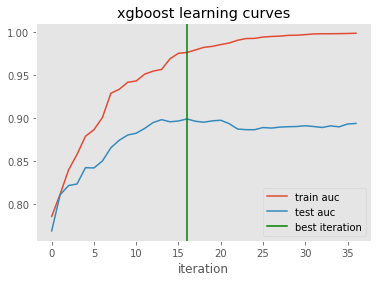

In [117]:
for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
plt.title('xgboost learning curves')
plt.legend()
plt.grid()

#### 3.5.3 Feature importance

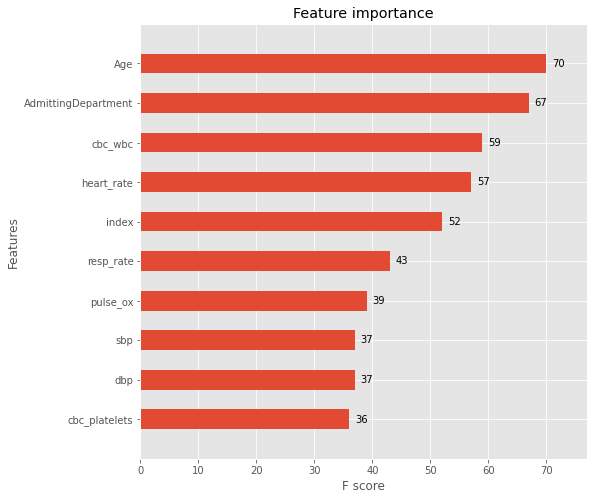

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [119]:
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_cols = [i[0] for i in sorted_x] + ['COVIDResult']
print(sorted_cols)

['Age', 'AdmittingDepartment', 'cbc_wbc', 'heart_rate', 'index', 'resp_rate', 'pulse_ox', 'dbp', 'sbp', 'cbc_platelets', 'cmp_bilirubin', 'cmp_creatinine', 'cmp_alt', 'cbc_lymphocyte_perc', 'cmp_bun', 'wght', 'cmp_glucose', 'cmp_alkaline_phosphatase', 'cbc_eosinophil_c', 'cmp_potassium', 'FirstRace', 'patno', 'cbc_hemoglobin', 'cmp_bicarbonate', 'Ethnicity', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'Admitted', 'cbc_lymphocyte_c', 'cmp_total_protein', 'cmp_ast', 'cmp_chloride', 'cbc_hematocrit', 'Sex', 'cbc_monocyte_c', 'cmp_sodium', 'cmp_albumin', 'height', 'COVIDResult']


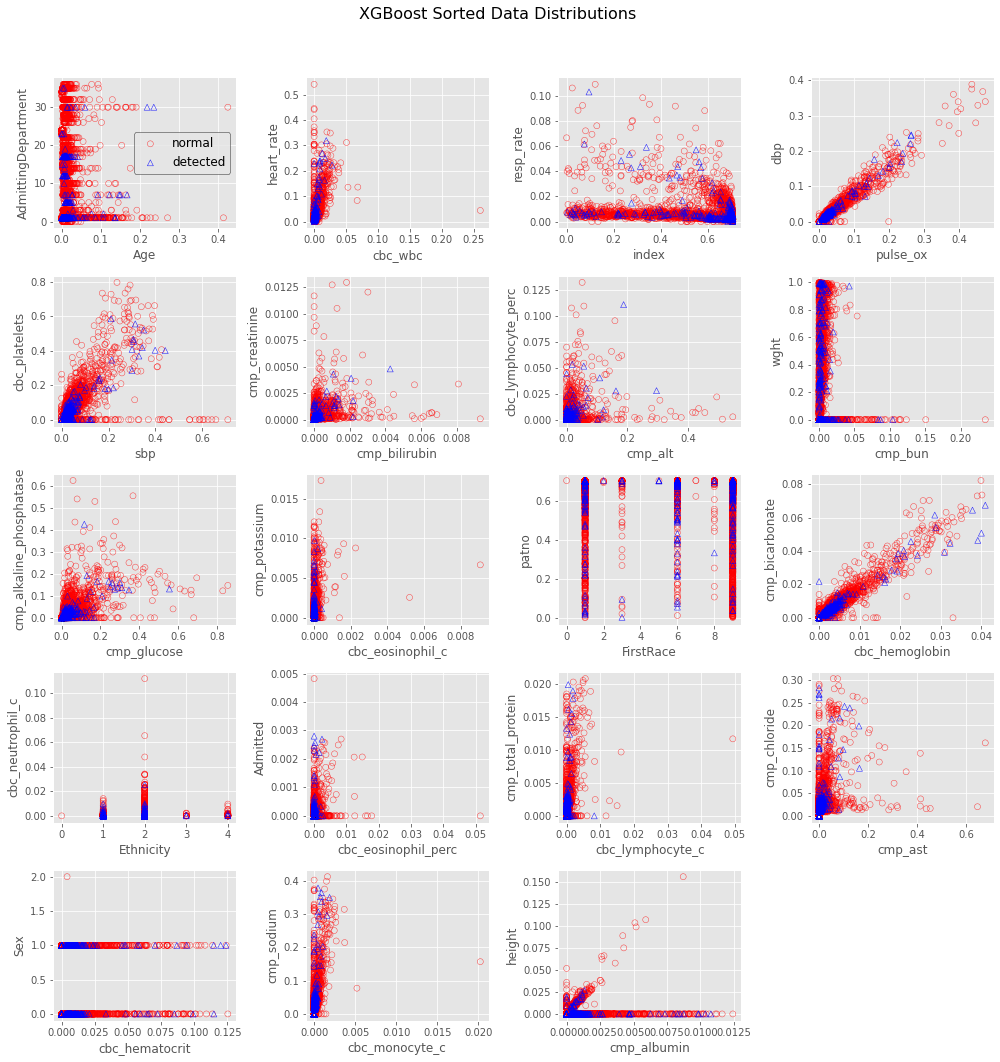

In [120]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('COVIDResult'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

#### 3.5.4 Ratio of normal:detected data

In [121]:
np.random.seed(seed)

n_real = np.sum(data_prepared.COVIDResult==0)
n_test = np.sum(data_prepared.COVIDResult==1)
real_samples = data_prepared.loc[ data_prepared.COVIDResult==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data_prepared.loc[ data_prepared.COVIDResult==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data_prepared.columns[:-1]
y_col = data_prepared.columns[-1]

test_data=[]

for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5,
                     num_boost_round=100,
                     early_stopping_rounds=10,
                     seed=0,
#                      feval=recall,
    )
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.100000,3,0.963814,0.013072,0.764372,0.029206
1,0.268270,11,0.998833,0.000625,0.807217,0.043959
2,0.719686,16,0.997959,0.000687,0.845141,0.016453
3,1.930698,15,0.992833,0.001410,0.857275,0.018428
4,5.179475,16,0.987055,0.002349,0.859440,0.021085
5,13.894955,30,0.997188,0.000490,0.868178,0.014068
6,37.275937,16,0.976525,0.002231,0.870183,0.012978
7,100.000000,16,0.976525,0.002231,0.870183,0.012978


***
## 4. Classification

### 4.1 Setup

In [122]:
# train = data_prepared.loc[ data_prepared['COVIDResult']==1 ].copy()
train = data_prepared

print( pd.DataFrame( [ [np.sum(train['COVIDResult']==i)] for i in np.unique(train['COVIDResult']) ], columns=['count'], index=np.unique(train['COVIDResult']) ) )

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
0   6910
1    470


### 4.2 Run algorithm

In [123]:
%%time
projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

CPU times: user 6min 30s, sys: 10.5 s, total: 6min 41s
Wall time: 2min 8s


0 KMeans
1 Agglomerative
2 HDBSCAN


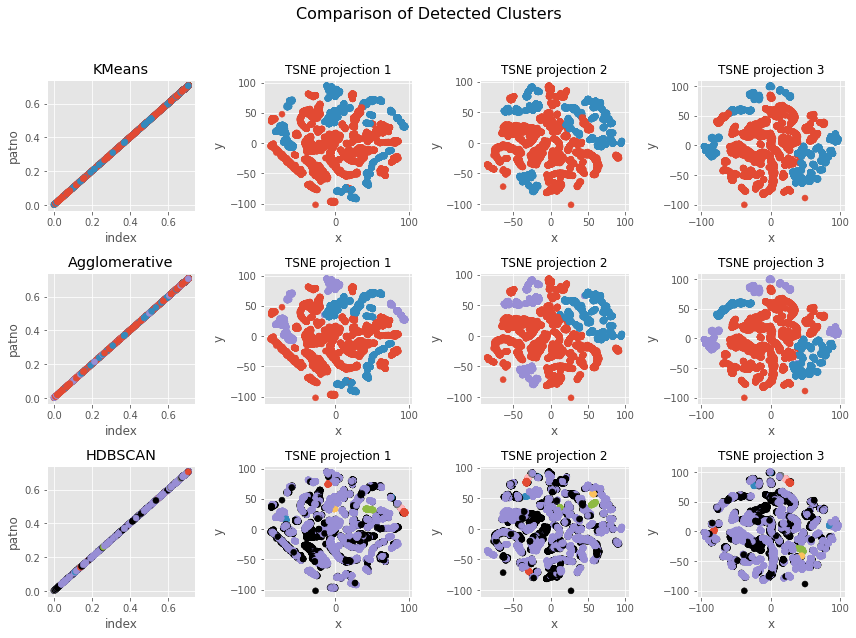

CPU times: user 8.28 s, sys: 457 ms, total: 8.74 s
Wall time: 8.51 s


In [124]:
%%time

algorithms = [ 
    [ 'KMeans', KMeans, (), {'n_clusters':2, 'random_state':seed} ],
    [ 'Agglomerative', AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)

plt.suptitle('Comparison of Detected Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

### 4.3 Add some labels

In [125]:
algorithm = KMeans
args, kwds = (), {'n_clusters':2, 'random_state':seed}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

detected_w_classes = train.copy()
detected_w_classes['COVIDResult'] = labels

   count
0   5443
1   1937


### 4.4 Feature importance

In [126]:
dtrain = xgb.DMatrix(detected_w_classes[data_cols], detected_w_classes['COVIDResult'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': seed,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )

Top eight features:  [['AdmittingDepartment', 10]]


***
## 5. Generative Adversarial Network

### 5.0 Reimport

In [127]:
importlib.reload(GAN) # For reloading after making changes
from GAN import *

### 5.1 Setup

In [128]:
rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = '../cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

train = detected_w_classes.copy().reset_index(drop=True) # detected only with labels from classification

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

### 5.2 Training the vanilla GAN and CGAN architectures

data_dim:  40
data_cols:  ['index', 'patno', 'Admitted', 'AdmittingDepartment', 'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.7123, 0.7008, 0.7299, 1.0000
D Real - D Gen: 0.0292


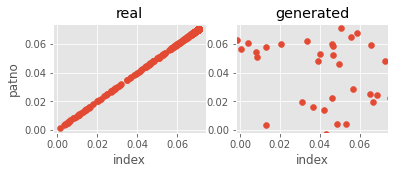

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2827, 0.4155, 0.5599, 1.0000
D Real - D Gen: 0.1444


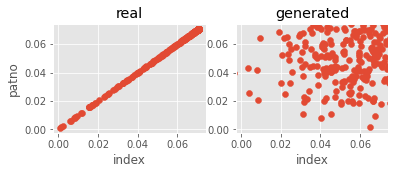

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0319, 0.5976, 0.6318, 0.9959
D Real - D Gen: 0.0342


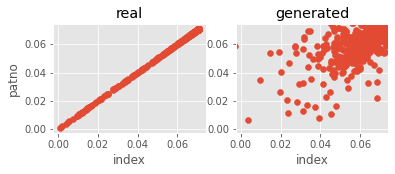

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9137, 0.6503, 0.6980, 0.9919
D Real - D Gen: 0.0476


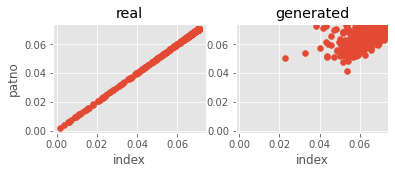

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9323, 0.6063, 0.6779, 0.9776
D Real - D Gen: 0.0715


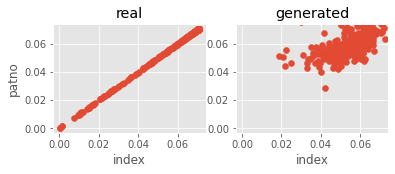

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9729, 0.5899, 0.6869, 0.9919
D Real - D Gen: 0.0970


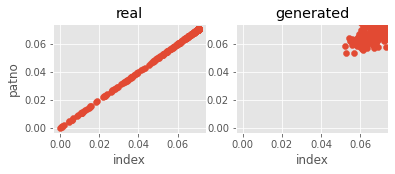

data_dim:  40
data_cols:  ['index', 'patno', 'Admitted', 'AdmittingDepartment', 'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin']
label_dim:  1
label_cols:  ['COVIDResult']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32)]         0                                            

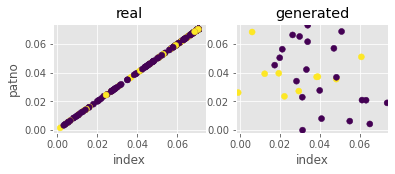

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.5675, 0.4255, 0.5219, 0.9980
D Real - D Gen: 0.0964


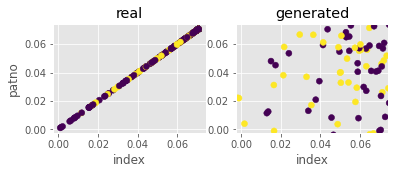

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9861, 0.6221, 0.7229, 0.9939
D Real - D Gen: 0.1008


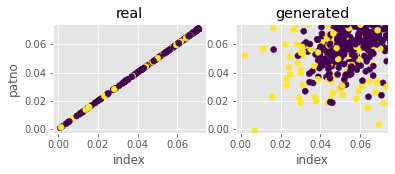

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8694, 0.6672, 0.7110, 0.9959
D Real - D Gen: 0.0438


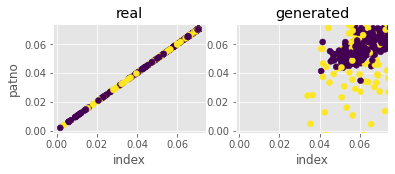

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9142, 0.6380, 0.7105, 0.9980
D Real - D Gen: 0.0725


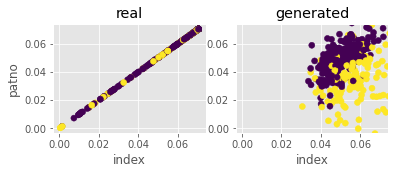

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8363, 0.7117, 0.6645, 0.9959
D Real - D Gen: -0.0471


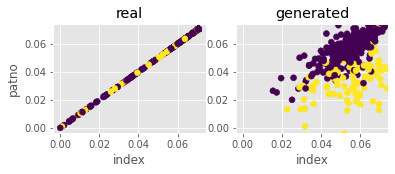

CPU times: user 1min 15s, sys: 4.87 s, total: 1min 20s
Wall time: 35.9 s


In [129]:
%%time

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

### 5.3 Training the WGAN and WCGAN architectures

In [130]:
# %%time

# k_d = 5 # train critic to optimal state each time
# learning_rate = 1e-4 # 5e-5
# arguments = [rand_dim, nb_steps, batch_size, 
#              k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
# adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

### 5.4 Reload loss data from pickles

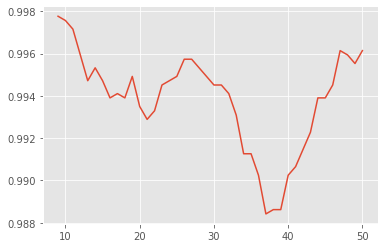

In [131]:
prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

### 5.5 Step with lowest xgboost accuracy and critic loss

In [132]:
best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

300 0.9776422764227642
300 0.9776422764227642


In [133]:
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

490 0.0027449802
500 0.003067702


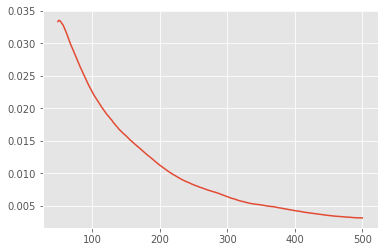

In [134]:
w = 50
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

***
## 6. Generated data

### 6.1 Setup

In [135]:
train = detected_w_classes.copy().reset_index(drop=True) # detected only with labels from classification

label_cols = [ i for i in train.columns if 'COVIDResult' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights(data_dir + 'CGAN_generator_model_weights_step_500.h5')

### 6.2 Generate some new data

0.9995934959349594


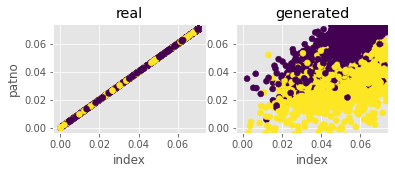

In [136]:
# test_size = 470 # Equal to all of the detected cases
test_size = 7380

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)
    
print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )
PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

### 6.3 XGBoost classifier on generated data

In [137]:
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

X_col = test_df.columns[:-2]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']
# y_true = test_df[y_col]

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': seed,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))
evaluation(y_pred, y_true)
# print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )
# SimpleMetrics(y_pred,y_true)

Confusion matrix:
[[3690    3]
 [   0 3687]]
Accuracy: 99.96%
Precision: 99.92%
Recall: 100.00%
F1 score: 99.96%


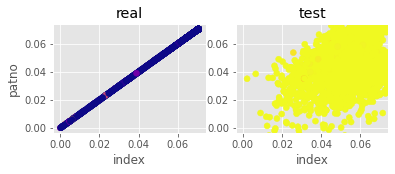

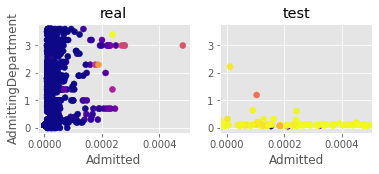

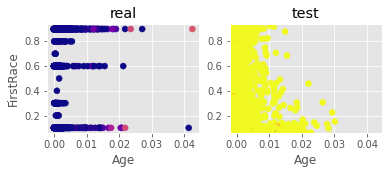

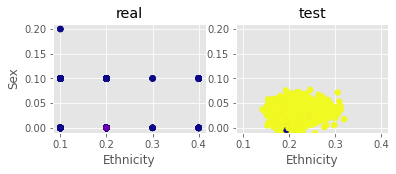

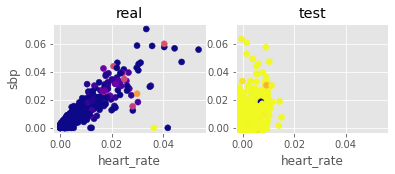

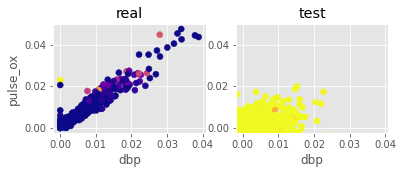

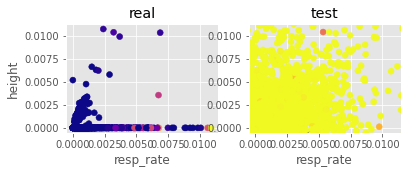

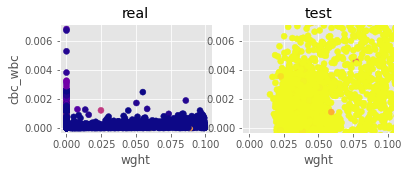

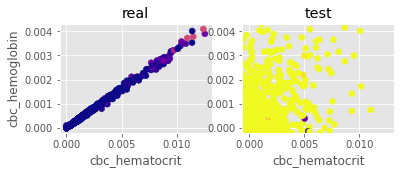

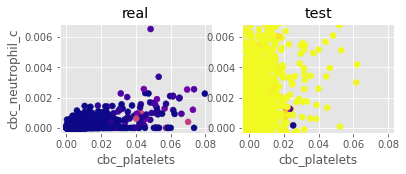

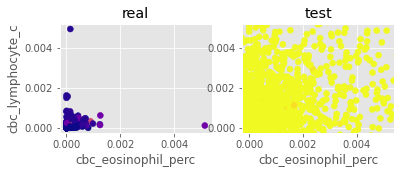

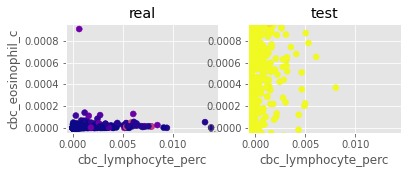

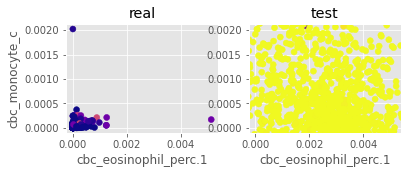

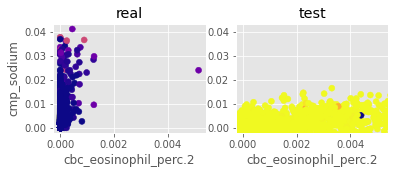

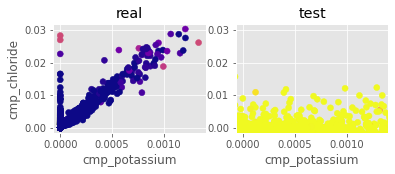

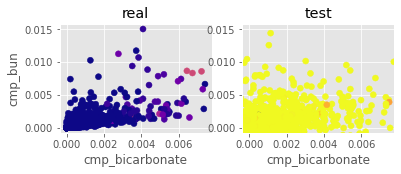

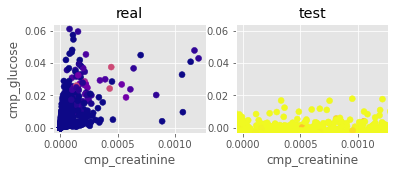

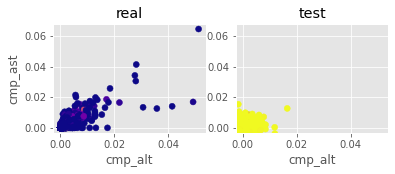

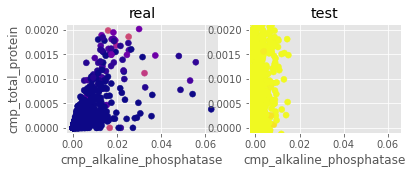

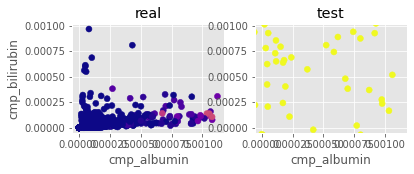

In [138]:
y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

### 6.4 Compare real and generated data

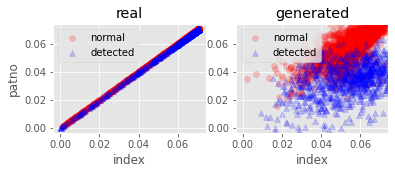

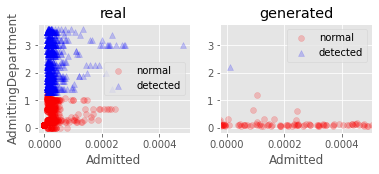

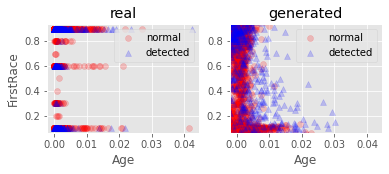

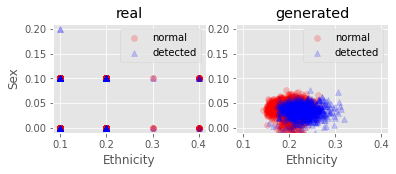

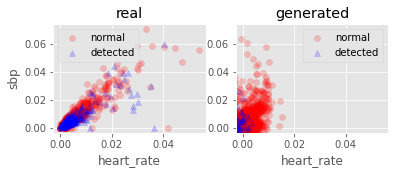

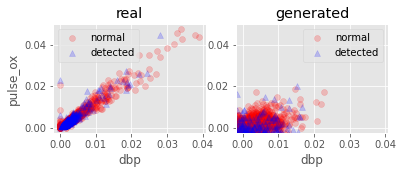

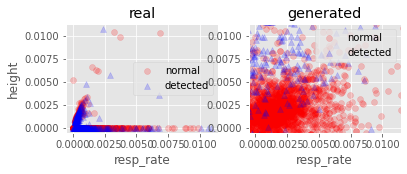

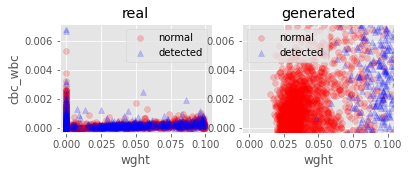

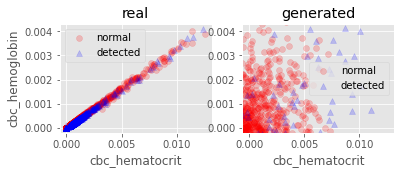

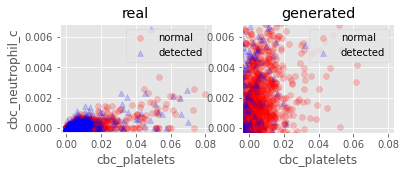

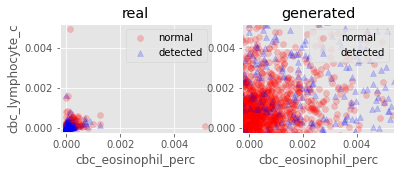

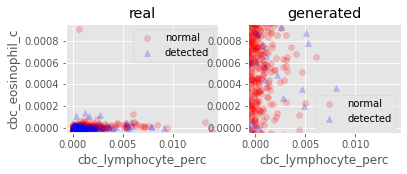

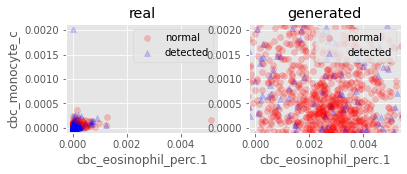

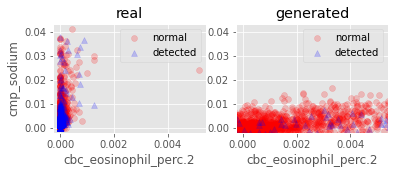

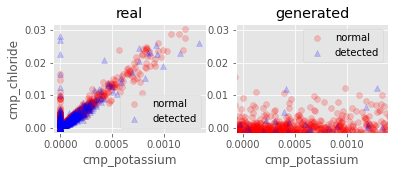

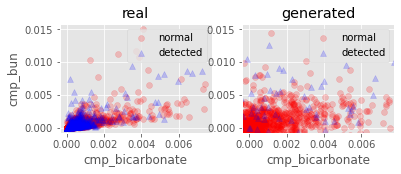

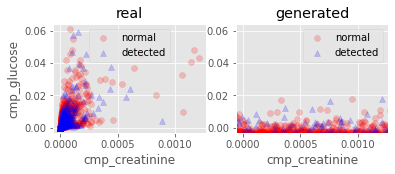

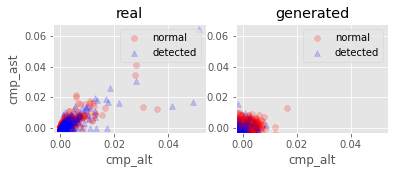

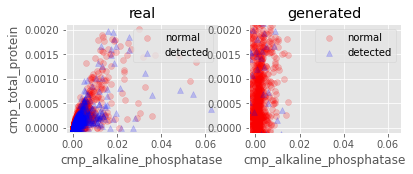

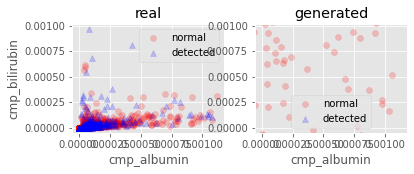

In [139]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']

class_label = 'COVIDResult'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

***
## 7. Feature importance

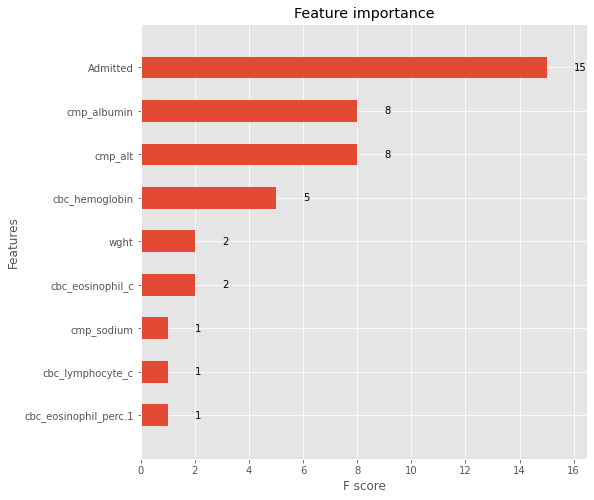

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

***
## 8. Model Retrained

In [141]:
x_train = train_df[X_col]
y_train = train_df[y_col]
x_test = test_df[X_col]
y_test = test_df[y_col]

lr = LogisticRegression(random_state=seed, max_iter=500)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[2855  835]
 [ 218 3472]]
Accuracy: 85.73%
Precision: 80.61%
Recall: 94.09%
F1 score: 86.83%


In [142]:
clf = BaggingClassifier(base_estimator=LogisticRegression(random_state=seed, max_iter=500), random_state=seed)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[2855  835]
 [ 231 3459]]
Accuracy: 85.56%
Precision: 80.55%
Recall: 93.74%
F1 score: 86.65%


In [143]:
bbc = BalancedBaggingClassifier(base_estimator=LogisticRegression(random_state=seed, max_iter=500),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=seed)
bbc.fit(x_train, y_train)
y_pred = bbc.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[2853  837]
 [ 214 3476]]
Accuracy: 85.76%
Precision: 80.59%
Recall: 94.20%
F1 score: 86.87%


In [144]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred)

Confusion matrix:
[[3690    0]
 [   0 3690]]
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


(array([3690.,    0., 3690.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

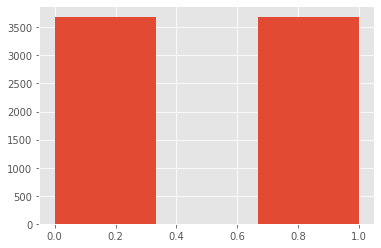

In [145]:
plt.hist(y_train, bins=3)

(array([3690.,    0., 3690.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

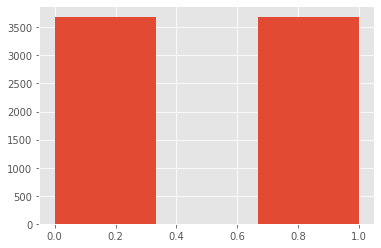

In [146]:
plt.hist(y_test, bins=3)

In [147]:
print(x_train.shape)
print(x_test.shape)
x_train

(7380, 40)
(7380, 40)


,index,patno,Admitted,AdmittingDepartment,Age,FirstRace,Ethnicity,Sex,heart_rate,sbp,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0.070553,0.070568,0.000000,0.100000,0.000390,0.300000,0.200000,0.100000,1.342971e-03,0.002483,...,0.000422,0.000203,0.000014,0.001999,0.001234,0.000687,0.000906,0.000120,0.000069,0.000009
1,0.068873,0.068919,0.000000,0.100000,0.002266,0.100000,0.200000,0.100000,2.312734e-03,0.006568,...,0.001203,0.000786,0.000042,0.010777,0.000971,0.001341,0.005504,0.000384,0.000227,0.000037
2,0.067660,0.067670,0.000000,0.100000,0.000736,0.900000,0.200000,0.100000,6.436984e-04,0.001308,...,0.000184,0.000184,0.000009,0.000817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.070548,0.070568,0.000000,0.100000,0.001514,0.900000,0.200000,0.100000,1.179732e-03,0.002477,...,0.000551,0.000295,0.000014,0.002124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.069407,0.069452,0.000045,2.200000,0.003696,0.900000,0.200000,0.100000,3.244986e-03,0.008383,...,0.001082,0.000721,0.000041,0.005228,0.001577,0.001803,0.010456,0.000311,0.000189,0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.061881,0.064940,-0.001365,0.295909,-0.001728,1.121941,0.198505,0.066357,2.896061e-03,0.011927,...,0.001212,0.006109,-0.007622,-0.000833,-0.004849,0.005100,0.003896,0.001140,-0.006278,-0.000612
3686,0.040471,0.041818,0.001208,0.171744,0.006820,0.091700,0.193410,0.012078,8.927881e-04,0.007484,...,-0.001571,-0.006189,0.007850,0.002637,0.000178,0.000889,0.003339,0.009567,-0.003192,-0.004327
3687,0.055819,0.060098,-0.001799,0.116261,0.004292,0.830501,0.181685,0.045701,7.179048e-04,0.004873,...,0.001463,0.001518,0.002153,-0.006953,0.000862,0.000102,0.000008,-0.000531,-0.000058,0.003179
3688,0.066110,0.065175,-0.002920,0.104983,-0.000038,0.935543,0.203616,0.049383,-3.749738e-07,0.005084,...,-0.000333,0.000592,-0.000405,-0.004740,-0.000003,-0.001075,0.001167,-0.001840,-0.002362,0.000056
